In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import re  
import warnings
import os 
warnings.filterwarnings("ignore")
%matplotlib inline
plt.rcParams['figure.figsize'] = [8,5]
plt.rcParams['font.size'] =14
plt.rcParams['font.weight']= 'bold'
sns.set()

In [2]:
import torch
import torch.nn as n 
import torch.optim as optim
import torch.nn.functional as F 
from torch.utils.data import DataLoader 
import torchvision.datasets as datasets 
import torchvision.transforms as tt
import torchtext
from textblob import TextBlob 
from wordcloud import WordCloud

In [3]:
df = pd.read_csv("./Dataset/Train.csv")
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


##Some Basic Insights:


*   What is the outlet that made the most money?
*   Does Outlet_Type affect sales?
*   Does Outlet_Location_Type affect sales?
*   What is the most sold item type?
*   In which year did we establish the most supermarkets? And why?
*   What is the most sold product?





In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


### We can see that "Item_Weight" & "Outlet_Type" contain null values. Therefore, we need to fill these values. We want to find columns that are correlated to these two columns to use IterativeImputer. Or, we could fill them using the mean value.

In [6]:
df['Item_Fat_Content'].unique()

array(['Low Fat', 'Regular', 'low fat', 'LF', 'reg'], dtype=object)

In [8]:
dic = {
    "Low Fat" : "low fat",
    "LF" : "low fat",
    "low fat" : "low fat",
    "reg" : "Regular",
    "Regular" : "Regular",
}
df['Item_Fat_Content'].map(dic).unique()

array(['low fat', 'Regular'], dtype=object)

In [9]:
df['Item_Fat_Content'] = df['Item_Fat_Content'].map(dic)

In [11]:
df['Item_MRP'].corr(df['Item_Weight'])
#weak correlation since it is not 1 or -1 or close to them.

0.027141153883330566

In [12]:
df['Item_Weight'].fillna(df['Item_Weight'].mean(), inplace = True)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                8523 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


###Insight 1:

In [18]:
print(df["Outlet_Identifier"].unique())
df["Outlet_Identifier"].nunique()

['OUT049' 'OUT018' 'OUT010' 'OUT013' 'OUT027' 'OUT045' 'OUT017' 'OUT046'
 'OUT035' 'OUT019']


10

In [21]:
highest_selling_outlet = df.groupby("Outlet_Identifier")["Item_Outlet_Sales"].sum().sort_values(ascending = False)

<BarContainer object of 10 artists>

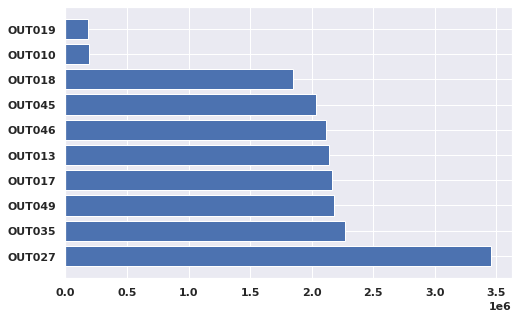

In [22]:
plt.barh(highest_selling_outlet.index, highest_selling_outlet.values)

###Insight 2:

In [32]:
hold = df[~((df["Outlet_Identifier"] == "OUT010") | (df["Outlet_Identifier"] == "OUT019"))].copy()

In [33]:
hold[hold["Outlet_Identifier"] == "OUT027"]["Outlet_Type"].value_counts()

Supermarket Type3    935
Name: Outlet_Type, dtype: int64

####We can see that the highest selling outlet is a Supermarket Type3.

In [34]:
hold[~(hold["Outlet_Identifier"] == "OUT027")]["Outlet_Type"].value_counts()

Supermarket Type1    5577
Supermarket Type2     928
Name: Outlet_Type, dtype: int64

####We can see that all the other are of type 1 and 2. Therefore, type 3 sells more.

In [36]:
hold.groupby("Outlet_Type")["Item_Outlet_Sales"].mean()

Outlet_Type
Supermarket Type1    2316.181148
Supermarket Type2    1995.498739
Supermarket Type3    3694.038558
Name: Item_Outlet_Sales, dtype: float64

####We can also see that type 1 is better at sales than type 2.